In [2]:
import os
import torchaudio
import torch
from torchmetrics import SignalNoiseRatio
import matplotlib.pyplot as plt
from torch.nn import Module,Sigmoid,LSTM, Linear, BCELoss, MSELoss, Conv1d, Conv2d, MaxPool2d, Transformer, LayerNorm, PReLU, Fold, ConvTranspose1d, MultiheadAttention, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import random
from torchmetrics import ScaleInvariantSignalNoiseRatio
import pickle
import math

/home/dfedorovsky/anaconda3/envs/beamformer/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
from DataLoader import DataLoaderOne

X,Y,speech,mix1,X_complex = DataLoaderOne.data_loader()

In [4]:
class PositionalEncoding(Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)



In [9]:
# TRANSFORMER MASK NET
NUMBER_OF_SPEAKERS = 4
SAMPLE_RATE = 16000
ENCODED_TIMESTEPS = int(50000/8) # 50000 is len of training data -> 50000/8 = 6250
FOLDS = int((ENCODED_TIMESTEPS/250)*2-1)
FILTERS = 32#256
D_TF = 128#1024

class TransformerMaskNet(Module):
    def __init__(self,noise=False):
        super(TransformerMaskNet, self).__init__()
        # ENCODER subnet
        self.tdnn = Conv1d(in_channels=1,out_channels=256,kernel_size=16,stride=8,padding=6)

        self.lnorm = LayerNorm(normalized_shape=(ENCODED_TIMESTEPS))
        self.lin0 = Linear(in_features=256, out_features=256)

        self.pe = PositionalEncoding(d_model=196)
        #self.pe2 = PositionalEncoding(d_model=250)
        self.ln11 = LayerNorm(normalized_shape=(513,196))
        self.ln12 = LayerNorm(normalized_shape=(513,196))
        self.ln21 = LayerNorm(normalized_shape=(513,196))
        self.ln22 = LayerNorm(normalized_shape=(513,196))
        self.ln31 = LayerNorm(normalized_shape=(513,196))
        self.ln32 = LayerNorm(normalized_shape=(513,196))
        self.ln41 = LayerNorm(normalized_shape=(513,196))
        self.ln42 = LayerNorm(normalized_shape=(513,196))

        self.mha1 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.mha2 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.mha3 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.mha4 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)

        self.lintf1 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf2 = Linear(in_features=196,out_features=D_TF)
        self.lintf3 = Linear(in_features=196,out_features=D_TF)
        self.lintf4 = Linear(in_features=196,out_features=D_TF)

        self.lintf12 = Linear(in_features=D_TF,out_features=196)
        self.lintf22 = Linear(in_features=D_TF,out_features=196)
        self.lintf32 = Linear(in_features=D_TF,out_features=196)
        self.lintf42 = Linear(in_features=D_TF,out_features=196)

        self.prelu = PReLU()
        self.lin1 = Linear(in_features=196, out_features=(196))

        # self.fold = Fold(output_size=(1,ENCODED_TIMESTEPS),kernel_size=(1,250),stride=(1,125))
        self.lin2 = Linear(in_features=196, out_features=196)
        self.sigmoid = Sigmoid()

        self.lstm = LSTM(input_size=4, hidden_size=64, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=128 ,out_features=1)

    def forward(self,x):

        x = x.reshape(NUMBER_OF_SPEAKERS,513,196)

        # Transformer 1
        y = self.pe(x)
        z = self.ln11(y)
        z, _ = self.mha1(z,z,z)
        z_2 = z+y
        z = self.ln12(z_2)
        z = self.lintf1(z)
        z = F.relu(z)
        z = self.lintf12(z)
        x = z+z_2+x
        # Transformer 2
        y = self.pe(x)
        z = self.ln21(y)
        z, _ = self.mha2(z,z,z)
        z_2 = z+y
        z = self.ln22(z_2)
        z = self.lintf2(z)
        z = F.relu(z)
        z = self.lintf22(z)
        x = z+z_2+x
        # # # Transformer 3
        # y = self.pe(x)
        # z = self.ln31(y)
        # z, _ = self.mha3(z,z,z)
        # z_2 = z+y
        # z = self.ln32(z_2)
        # z = self.lintf3(z)
        # z = F.relu(z)
        # z = self.lintf32(z)
        # x = z+z_2+x
        # # Transformer 4
        # y = self.pe(x)
        # z = self.ln41(y)
        # z, _ = self.mha4(z,z,z)
        # z_2 = z+y
        # z = self.ln42(z_2)
        # z = self.lintf4(z)
        # z = F.relu(z)
        # z = self.lintf42(z)
        # x = z+z_2+x

        # PRELU and Linear
        x = self.prelu(x)
        x = x.view(NUMBER_OF_SPEAKERS,513,196)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = x.view(513,196,NUMBER_OF_SPEAKERS)
        x = F.relu(x)

        x = x.view(513,196,NUMBER_OF_SPEAKERS)
        # y, (h_n, c_n) = self.lstm(x)
        # x = self.fc(y)
        x = self.sigmoid(x).view(NUMBER_OF_SPEAKERS,513,196)
        return x[0]
    
print(summary(TransformerMaskNet(),torch.zeros((4, 513, 196))))

---------------------------------------------------------------------------------------
           Layer (type)                   Output Shape         Param #     Tr. Param #
   PositionalEncoding-1                  [4, 513, 196]               0               0
            LayerNorm-2                  [4, 513, 196]         201,096         201,096
   MultiheadAttention-3     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-4                  [4, 513, 196]         201,096         201,096
               Linear-5                  [4, 513, 128]          25,216          25,216
               Linear-6                  [4, 513, 196]          25,284          25,284
            LayerNorm-7                  [4, 513, 196]         201,096         201,096
   MultiheadAttention-8     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-9                  [4, 513, 196]         201,096         201,096
              Linear-10                  [

In [13]:
EPOCHS = 2
LEN_TRAIN = 200
BATCH_SIZE = 1
INIT_LR = 0.00001 #0.001 is too high
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'
MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TFmask'
TRS = 0.2

CUDA = True # if torch.cuda.is_available()
device =  torch.device("cuda:3") if torch.cuda.is_available() else torch.device('cpu')
print("Mounted on:", device)

lossBCE = BCELoss().to(device)

model = TransformerMaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[3])
opt = Adam(model.parameters(), lr=INIT_LR)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.96,last_epoch=-1)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>TRS).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(speech)-len(trainX))+len(trainX))
    model.eval()
    pred = model(X[example_nr])
    #noise_pred = torch.ones([513,196]).to(device)-pred
    val_loss = lossBCE(pred,Y[example_nr][0])#+lossBCE(noise_pred,Y[example_nr][1])
    pred = (pred>TRS).float()
    model.train()
    return float(torch.sum((pred == Y[example_nr][0]).float())/torch.sum(torch.ones(513,X[example_nr].shape[1])).to(device)),val_loss

print("[INFO] training the network...")

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    trainX = X[:LEN_TRAIN].to(device)
    trainY = Y.to(device)
    Y = trainY
    speech_pred = 0
    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        (x, y) = (trainX[i],trainY[i][0])
        speech_pred=model(x)
        #noise_pred = torch.ones([513,196]).to(device)-speech_pred
        loss = lossBCE(speech_pred,y)#+lossBCE(noise_pred,y[1])
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        if i % 10 == 0:
            lr_scheduler.step()
        H["train_acc"].append(check_accuracy_training(speech_pred,y[0]))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            val_acc, val_loss = check_accuracy_validation(model)
            H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    print("Average Training Loss at Epoch",str(epoch+1),":",(sum(H["train_loss"][-2000:]))/2000)
    print("Average Validation Loss at Epoch",str(epoch+1),":",(sum(H["val_loss"][-200:]))/200)
    print("Average Training Accuracy at Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Average Validation Accuracy at Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    # Save
    torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch"+ str(epoch+1) + ".pt")
    print(speech_pred)

torch.save(model.state_dict(), MODEL_SAVE_PATH + "final" + ".pt")
with open(PICKLE_SAVE_PATH, 'wb') as f:
    pickle.dump(H, f)

Mounted on: cuda:3
[INFO] training the network...
Epoch: 1/2


100%|██████████| 200/200 [00:02<00:00, 75.59it/s]


Average Training Loss at Epoch 1 : 0.08756917124986649
Average Validation Loss at Epoch 1 : 0.087247334420681
Average Training Accuracy at Epoch 1 : 0.1988265232834965
Average Validation Accuracy at Epoch 1 : 0.2579892218112946
tensor([[0.5000, 0.7752, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.6740, 0.6229, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.7025, 0.7337, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.6459, 0.5552, 0.5000,  ..., 0.5000, 0.5753, 0.5000],
        [0.5820, 0.6695, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5886, 0.5363, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       device='cuda:3', grad_fn=<SelectBackward0>)
Epoch: 2/2


100%|██████████| 200/200 [00:02<00:00, 79.41it/s]


Average Training Loss at Epoch 2 : 0.1683723183274269
Average Validation Loss at Epoch 2 : 0.16733326405286789
Average Training Accuracy at Epoch 2 : 0.1988265232834965
Average Validation Accuracy at Epoch 2 : 0.26589912325143816
tensor([[0.6217, 0.7063, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.6074, 0.7082, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.6683, 0.7131, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.6190, 0.6136, 0.5000,  ..., 0.5000, 0.6527, 0.5000],
        [0.5936, 0.7017, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5962, 0.6055, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       device='cuda:3', grad_fn=<SelectBackward0>)


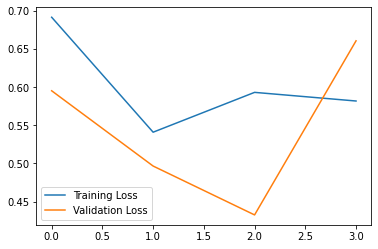

In [7]:
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'

with open(PICKLE_SAVE_PATH, 'rb') as f:
    H = pickle.load(f)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

n = 10
#plt.plot(running_mean(H["train_loss"][::n*10],100))
#plt.plot(running_mean(H["val_loss"][::n],100))
plt.plot(H["train_loss"][::n*10])
plt.plot(H["val_loss"][::n])
plt.legend(['Training Loss', 'Validation Loss'])

In [7]:
MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/'

MODEL_NAME = "TFmaskfinal.pt"
state_dict = torch.load(MODEL_SAVE_PATH+MODEL_NAME)

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.` from state dict
    new_state_dict[name] = v
# load params
model = TransformerMaskNet()
model.load_state_dict(new_state_dict)

model.eval()

TransformerMaskNet(
  (tdnn): Conv1d(1, 256, kernel_size=(16,), stride=(8,), padding=(6,))
  (lnorm): LayerNorm((6250,), eps=1e-05, elementwise_affine=True)
  (lin0): Linear(in_features=256, out_features=256, bias=True)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln11): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln12): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln21): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln22): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln31): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln32): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln41): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (ln42): LayerNorm((513, 196), eps=1e-05, elementwise_affine=True)
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (mha2): MultiheadAttention(
 

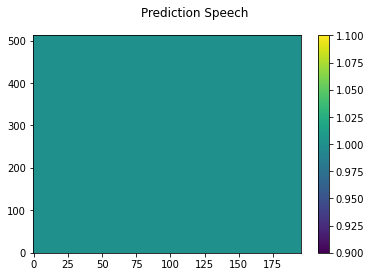

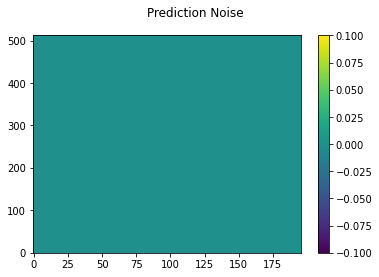

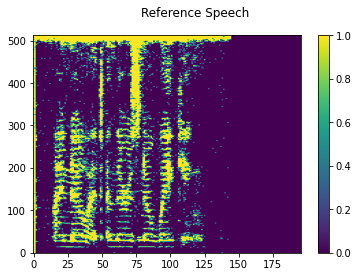

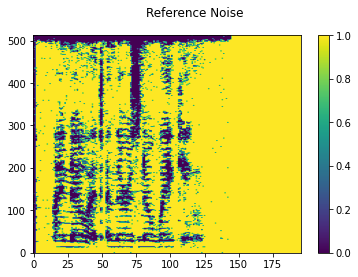

In [8]:
X = X.cpu()
Y = Y.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(X[e_nr])>0.2).float()
    noise_pred = torch.ones([513,X[e_nr].shape[1]])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y[e_nr][0], title="Reference Speech")
    plot_mask(Y[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

evaluate_example(1)

In [34]:
istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256)

def evaluateSiSNR(wave, i):
    def si_snr(estimate, reference, epsilon=1e-8):
        estimate = estimate - estimate.mean()
        reference = reference - reference.mean()
        reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
        mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
        scale = mix_pow / (reference_pow + epsilon)

        reference = scale * reference
        error = estimate - reference

        reference_pow = reference.pow(2)
        error_pow = error.pow(2)

        reference_pow = reference_pow.mean(axis=1)
        error_pow = error_pow.mean(axis=1)

        si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
        return si_snr.item()
    score = si_snr(wave, speech[i])
    print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    torchaudio.save("./outputs/output.wav",wave.reshape(1,-1),16000)
    torchaudio.save("./outputs/sample_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/sample_input.wav", mix1[i].reshape(1,-1),sample_rate)

index = 201
speech_pred = (model(X[index])>0.2).float()
noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
print(wave.shape)
print(wave)
save_sample(index, wave=wave)
score = evaluateSiSNR(wave,index)#Should be ~28

torch.Size([50000])
tensor([-0.0089, -0.0086, -0.0083,  ...,  0.0365,  0.0402,  0.0460])
Si-SNR score: -7.393011093139648
